In [3]:
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from timeit import default_timer as timer
from datetime import timedelta
import random
from collections import deque
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import time

In [4]:
def test_policy(P, R, policy, test_count=1000):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                #print(probs)
                next_state =  np.random.choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action]
                episode_reward += reward
                # when go back to 0 ended
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / total_episode

In [5]:
def value_iteration(P, R, gamma=.99, eps=.0001):
    vi = ValueIteration(P, R, gamma, epsilon=eps)
    vi.run()
    return vi

In [6]:
def policy_iteration(P, R, gamma=.99):
    pi = PolicyIteration(P, R, gamma)
    pi.run()
    return pi

In [7]:
def train_and_test_vi(P, R, discount_factors=[0.9], epsilons=[1e-9]):
    vi_dict = {}
    for dis in discount_factors:
        vi_dict[dis] = {}
        for eps in epsilons:
            vi_dict[dis][eps] = {}
            vi = value_iteration(P, R, dis, eps)
            #mean_reward = test_policy(P, R, vi.policy)    
            #vi_dict[dis][eps]["mean_reward"] = mean_reward
            #vi_dict[dis][eps]["mean_eps"] = mean_eps
            vi_dict[dis][eps]["iteration"] = vi.iter
            vi_dict[dis][eps]["time_spent"] = vi.time
            vi_dict[dis][eps]["policy"] = vi.policy
    return vi_dict

In [8]:
def train_and_test_pi(P, R, discount_factors=[0.9]):
    pi_dict = {}
    for dis in discount_factors:
        pi_dict[dis] = {}
        pi = policy_iteration(P, R, dis)
        #mean_reward = test_policy(P, R, pi.policy)    
        #pi_dict[dis]["mean_reward"] = mean_reward
        #pi_dict[dis]["mean_eps"] = mean_eps
        pi_dict[dis]["iteration"] = pi.iter
        pi_dict[dis]["time_spent"] = pi.time
        pi_dict[dis]["policy"] = pi.policy
    return pi_dict

In [12]:
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

In [13]:
def plot_policy(policy):
    ax=[[p for p in policy]]
    for i in range(len(ax[0])):
        a = 'W'
        if ax[0][i] == 1:
            a = 'C'
        text = plt.text(i,0, a,
                    ha="center", va="center", color="r")
        highlight_cell(i,0, color="lightgreen", linewidth=3)

    plt.imshow(ax, interpolation="nearest")
    plt.axis('off')
    plt.show()
    

# Forest 20 States

In [9]:
from hiive.mdptoolbox.example import forest
np.random.seed(40)
env_20_P, env_20_R = forest(S=10, r1=10, r2=5, p=0.1, is_sparse=False)

# Value Iteration

In [196]:
def train_different_vi_gamma():
    discount_factors = np.linspace(0.5, 0.99, num=5)
    scores_gamma = {}
    for gamma in discount_factors:
        print("discount factor: {:.6f}\n".format(gamma), end="")
        vi = value_iteration(env_20_P,env_20_R, gamma, 1e-15)
        mean_v= [stat['Mean V'] for stat in vi.run_stats]
        scores_gamma[gamma] = mean_v
    return scores_gamma

In [78]:
def plot_scores_2_discount_factor_vi_pi(scores_gamma):
    scores_discount_factor_pd = None
    for discount in np.linspace(0.5, 0.99, num=5):
        df = pd.DataFrame(pd.Series(list(scores_gamma[discount])),
                          columns=[r"$\gamma$=" + '{:.4f}'.format(discount)])
        scores_discount_factor_pd = pd.concat([scores_discount_factor_pd, df], axis=1)
    scores_discount_factor_pd = scores_discount_factor_pd.fillna(method='ffill')
    scores_discount_factor_pd['Episodes'] = np.arange(scores_discount_factor_pd.shape[0])
    ax = plt.gca()
    plt.ylabel("Mean V")
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[0], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[1], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[2], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[3], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[4], ax=ax)
    plt.show()

In [197]:
scores_gamma_vi=train_different_vi_gamma()

discount factor: 0.500000
discount factor: 0.622500
discount factor: 0.745000
discount factor: 0.867500
discount factor: 0.990000


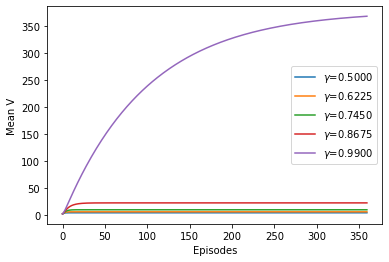

In [80]:
plot_scores_2_discount_factor_vi_pi(scores_gamma)

In [10]:
start = time.time()
vi = value_iteration(env_20_P,env_20_R, gamma=0.99,eps=1e-15)
elapsed_time = time.time() - start
print(elapsed_time)

0.025943279266357422


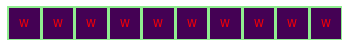

In [84]:
plot_policy(vi.policy)

In [170]:
discount_factors = np.linspace(0.5, 0.99, num=5)
epsilons=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15]
vi_dict = train_and_test_vi(env_20_P,env_20_R ,discount_factors, epsilons)

(0, 1, 1, 1, 1, 1, 1, 1, 0, 0)


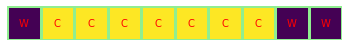

In [190]:
env_hp_20_P, env_hp_20_R = forest(S=10, r1=10, r2=5, p=0.9, is_sparse=False)
vi = value_iteration(env_hp_20_P,env_hp_20_R, gamma=0.99,eps=1e-15)
print(vi.policy)
plot_policy(vi.policy)

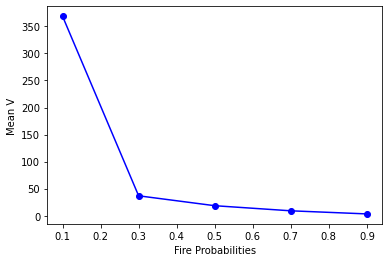

In [192]:
rewards=[]
fire_probs = np.linspace(0.1, 0.9, num=5)
for fire_prob in fire_probs:
    env_20_P, env_20_R = forest(S=10, r1=10, r2=5, p=fire_prob, is_sparse=False)
    vi = value_iteration(env_20_P,env_20_R, gamma=0.99,eps=1e-15)
    rewards.append(np.mean(vi.V))
    
plt.plot(fire_probs, rewards, color='b', marker='o')
plt.xlabel('Fire Probabilities')
plt.ylabel('Mean V')
plt.show()

# Policy Iteration

In [171]:
discount_factors = np.linspace(0.5, 0.99, num=5)
pi_dict = train_and_test_pi(env_20_P,env_20_R ,discount_factors)

In [194]:
def train_different_pi_gamma():
    discount_factors = np.linspace(0.5, 0.99, num=5)
    scores_gamma = {}
    for gamma in discount_factors:
        print("discount factor: {:.6f}\n".format(gamma), end="")
        vi = policy_iteration(env_20_P,env_20_R, gamma)
        mean_v= [stat['Mean V'] for stat in vi.run_stats]
        scores_gamma[gamma] = mean_v
    return scores_gamma

In [195]:
scores_gamma_pi=train_different_pi_gamma()

discount factor: 0.500000
discount factor: 0.622500
discount factor: 0.745000
discount factor: 0.867500
discount factor: 0.990000


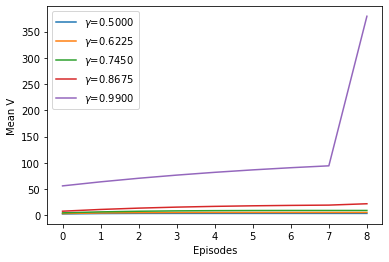

In [24]:
plot_scores_2_discount_factor_vi_pi(scores_gamma)

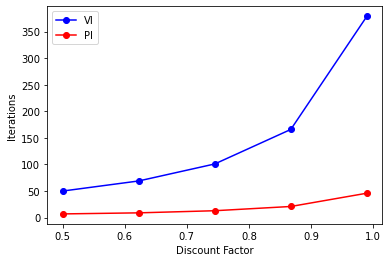

In [202]:
vi_iters=[vi_dict[disc][1e-15]['iteration']for disc in vi_dict]
pi_iters=[pi_dict[disc]['iteration'] for disc in pi_dict]
plt.plot(discount_factors, vi_iters, label='VI', color='b', marker='o')
plt.plot(discount_factors, pi_iters, label='PI', color='r', marker='o')
plt.xlabel('Discount Factor')
plt.ylabel('Iterations')
plt.legend(loc=0)
plt.show()

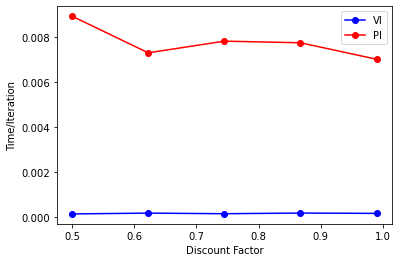

In [201]:
vi_time_spent=[vi_dict[disc][1e-15]['time_spent']/vi_dict[disc][1e-15]['iteration']for disc in vi_dict]
pi_time_spent=[pi_dict[disc]['time_spent']/pi_dict[disc]['iteration'] for disc in pi_dict]
plt.plot(discount_factors, vi_time_spent, label='VI', color='b', marker='o')
plt.plot(discount_factors, pi_time_spent, label='PI', color='r', marker='o')
plt.xlabel('Discount Factor')
plt.ylabel('Time/Iteration')
plt.legend(loc=0)
plt.show()

0.007548093795776367
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


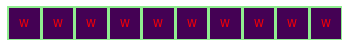

In [14]:
start = time.time()
pi = policy_iteration(env_20_P,env_20_R, gamma=0.99)
elapsed_time = time.time() - start
print(elapsed_time)
print(pi.policy)
plot_policy(pi.policy)

(0, 1, 1, 1, 1, 1, 1, 1, 0, 0)


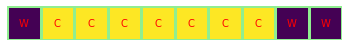

In [187]:
env_hp_20_P, env_hp_20_R = forest(S=10, r1=10, r2=5, p=0.9, is_sparse=False)
pi = policy_iteration(env_hp_20_P,env_hp_20_R, gamma=0.99)
print(pi.policy)
plot_policy(pi.policy)

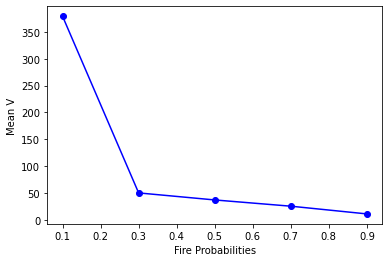

In [167]:
rewards=[]
fire_probs = np.linspace(0.1, 0.9, num=5)
for fire_prob in fire_probs:
    env_20_P, env_20_R = forest(S=10, r1=10, r2=5, p=fire_prob, is_sparse=False)
    pi = policy_iteration(env_20_P, env_20_R, 0.99)
    rewards.append( np.mean(pi.V))
    
plt.plot(fire_probs, rewards, color='b', marker='o')
plt.xlabel('Fire Probabilities')
plt.ylabel('Mean V')
plt.show()

# Q-Learning

In [15]:
def q_learning_forest(P, R, discount=0.99, eps_min=0.0001, eps_decay=0.99, lr_decay=0.99, lr=0.0001, iter=1000000):
    q = QLearning(P, R, gamma=discount,  alpha=0.1, alpha_decay=lr_decay, alpha_min=lr,
                epsilon_min=eps_min, epsilon_decay=eps_decay,
                n_iter=iter)
    q.run()
    return q

In [17]:
start = time.time()
q_learn = q_learning_forest(env_20_P,env_20_R,discount=0.99,lr_decay=.99,eps_decay=0.625)
train_scores = [st['Mean V'] for st in q_learn.run_stats]
elapsed_time = time.time() - start
print(elapsed_time)
#print(train_scores)
print(q_learn.policy)
print(q_learn.V)

43.49282455444336
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0)
(1.096382887063951, 1.1810158676694529, 1.2851855337164166, 1.4115645408339714, 1.5613818532032075, 1.7450241319509252, 1.961646958748019, 0.060338200502873106, 1.886701102367272, 23.04323920262749)


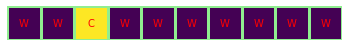

In [205]:
plot_policy(q_learn.policy)

In [28]:
def plot_training_graphs(train_scores, discount=0.99, lr_decay=0.99, decay_rate=0.625):
    lr_patch = mpatches.Patch(label=r"$\alpha$-decay=" + str(lr_decay), color='green')
    gamma_patch = mpatches.Patch(label=r"$\gamma$=" + str(discount), color='green')
    epsilon_decay_patch = mpatches.Patch(label='eps_decay=' + str(decay_rate), color='green')
    scores_df = pd.DataFrame(train_scores)
    #scores_df['rolling_mean'] = scores_df[scores_df.columns[0]].rolling(1000).mean()
    scores_df['Episodes'] = np.arange(scores_df.shape[0])
    ax = plt.gca()
    #ax.set_title('Training Rewards')
    plt.ylabel("Mean V")
    colors = ['tab:blue', 'red']
    scores_df.plot(color=colors, kind='line', x='Episodes', linewidth=2, ax=ax)
    plt.legend(handles=[lr_patch, gamma_patch,epsilon_decay_patch],loc='upper left')
    plt.show()

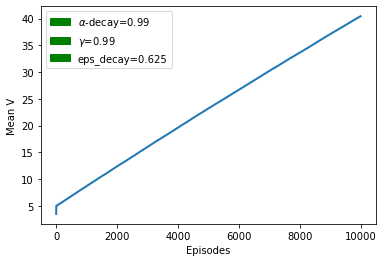

In [155]:
plot_training_graphs(train_scores)

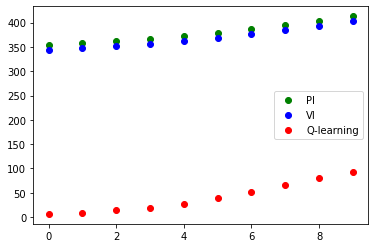

In [164]:
states = list(range(0, len(q_learn.V)))
plt.scatter(states, pi.V, label='PI', color='g', marker='o')
plt.scatter(states, vi.V, label='VI', color='b', marker='o')
plt.scatter(states, q_learn.V, label='Q-learning', color='r', marker='o')
plt.legend()
plt.show()

In [114]:
def train_different_discount_rate():
    scores_gamma = {}
    gammas = np.linspace(0.5, 0.99, num=5)
    for gamma in gammas:
        print("discount rate: {:.3f}\n".format(gamma), end="")
        q_learn = q_learning_forest(env_20_P, env_20_R, discount=gamma)
        scores_gamma[gamma] = [st['Mean V'] for st in q_learn.run_stats]
    pickle.dump(scores_gamma, open("results_forest/scores_gamma.p", "wb"))

In [115]:
train_different_discount_rate()

discount rate: 0.500
discount rate: 0.623
discount rate: 0.745
discount rate: 0.867
discount rate: 0.990


In [129]:
def plot_scores_2_discount_factor():
    gammas = np.linspace(0.5, 0.99, num=5)
    scores_discount_factor = pickle.load(open("results_forest/scores_gamma.p", "rb"))
    scores_discount_factor_pd = None
    for discount in gammas:
        df = pd.DataFrame(pd.Series(list(scores_discount_factor[discount])).rolling(1000).mean(),
                          columns=[r"$\gamma$=" + '{:.3f}'.format(discount)])
        scores_discount_factor_pd = pd.concat([scores_discount_factor_pd, df], axis=1)
    scores_discount_factor_pd = scores_discount_factor_pd.fillna(method='ffill')
    scores_discount_factor_pd['Episodes'] = np.arange(scores_discount_factor_pd.shape[0])
    ax = plt.gca()
    ax.set_title('1000 Episodes Moving Average')
    plt.ylabel('Mean V')
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[0], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[1], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[2], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[3], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[4], ax=ax)
    plt.show()

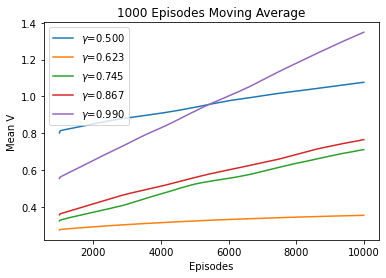

In [130]:
plot_scores_2_discount_factor()

In [122]:
def train_different_lr():
    lr_decays = np.linspace(0.5, 0.99, num=5)
    scores_lr = {}
    for lr in lr_decays:
        print("learning rate: {:.6f}\n".format(lr), end="")
        q_learn = q_learning_forest(env_20_P, env_20_R, lr_decay=lr)
        scores_lr[lr] =[st['Mean V'] for st in q_learn.run_stats]
    pickle.dump(scores_lr, open("results_forest/scores_lr.p", "wb"))

In [123]:
train_different_lr()

learning rate: 0.500000
learning rate: 0.622500
learning rate: 0.745000
learning rate: 0.867500
learning rate: 0.990000


In [36]:
def plot_scores_2_learning_rate():
    lr_decays = np.linspace(0.5, 0.99, num=5)
    scores_lr = pickle.load(open("results_forest/scores_lr.p", "rb"))
    scores_lr_pd = None
    for lr in lr_decays:
        df = pd.DataFrame(pd.Series(list(scores_lr[lr])).rolling(1000).mean(),
                          columns=[r"$\alpha$-decay=" + '{:.3f}'.format(lr)])
        scores_lr_pd = pd.concat([scores_lr_pd, df], axis=1)
    scores_lr_pd = scores_lr_pd.fillna(method='ffill')
    scores_lr_pd['Episodes'] = np.arange(scores_lr_pd.shape[0])
    ax = plt.gca()
    ax.set_title('1000 Episodes Moving Average')
    plt.ylabel('Mean V')
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[0], ax=ax)
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[1], ax=ax)
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[2], ax=ax)
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[3], ax=ax)
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[4], ax=ax)
    plt.show()


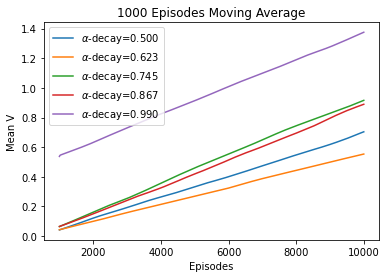

In [37]:
plot_scores_2_learning_rate()

In [127]:
def train_different_epsilon_decays():
    scores_epsilon_decays = {}
    epsilon_decays = np.linspace(0.5, 0.99, num=5)
    for epsilon_decay in epsilon_decays:
        print("epsilon decay: {}\n".format(epsilon_decay), end="")
        q_learn = q_learning_forest(env_20_P, env_20_R, eps_decay=epsilon_decay)
        scores_epsilon_decays[epsilon_decay] = [st['Mean V'] for st in q_learn.run_stats]
    pickle.dump(scores_epsilon_decays, open("results_forest/scores_epsilon_decays.p", "wb"))

In [128]:
train_different_epsilon_decays()

epsilon decay: 0.5
epsilon decay: 0.6225
epsilon decay: 0.745
epsilon decay: 0.8674999999999999
epsilon decay: 0.99


In [133]:
def plot_scores_2_epsilon_decays_graph():
    #epsilon_decays = np.linspace(0.5, 0.99, num=5)
    epsilon_decays = np.linspace(0.5, 0.99, num=5) 
    scores_epsilon_decays = pickle.load(open("results_forest/scores_epsilon_decays.p", "rb"))
    scores_epsilon_decays_pd = None
    for epsilon_decay in epsilon_decays:
        df = pd.DataFrame(pd.Series(list(scores_epsilon_decays[epsilon_decay])).rolling(1000).mean(),
                          columns=["eps decay =" + '{:.3f}'.format(epsilon_decay)])
        scores_epsilon_decays_pd = pd.concat([scores_epsilon_decays_pd, df], axis=1)
    scores_epsilon_decays_pd = scores_epsilon_decays_pd.fillna(method='ffill')
    scores_epsilon_decays_pd['Episodes'] = np.arange(scores_epsilon_decays_pd.shape[0])
    ax = plt.gca()
    ax.set_title('1000 Episodes Moving Average')
    plt.ylabel('Mean V')
    scores_epsilon_decays_pd.plot(kind='line', x='Episodes', y=scores_epsilon_decays_pd.columns[0], ax=ax)
    scores_epsilon_decays_pd.plot(kind='line', x='Episodes', y=scores_epsilon_decays_pd.columns[1], ax=ax)
    scores_epsilon_decays_pd.plot(kind='line', x='Episodes', y=scores_epsilon_decays_pd.columns[2], ax=ax)
    scores_epsilon_decays_pd.plot(kind='line', x='Episodes', y=scores_epsilon_decays_pd.columns[3], ax=ax)
    scores_epsilon_decays_pd.plot(kind='line', x='Episodes', y=scores_epsilon_decays_pd.columns[4], ax=ax)
    plt.show()

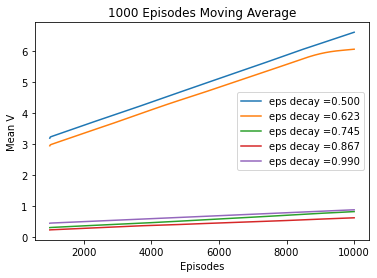

In [134]:
plot_scores_2_epsilon_decays_graph()

# Forest 500 States

In [20]:
env_500_P, env_500_R= forest(S=500, r1=100, r2=10, p=0.1, is_sparse=False)

0.05825972557067871


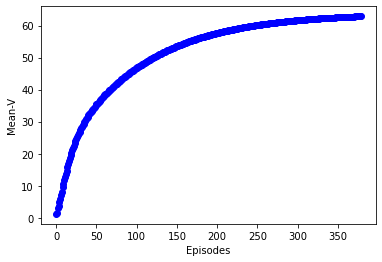

In [42]:
start = time.time()
vi = value_iteration(env_500_P,env_500_R, gamma=0.99, eps=1e-15)
elapsed_time = time.time() - start
print(elapsed_time)
mean_v= [stat['Mean V'] for stat in vi.run_stats]
plt.plot(mean_v, color='b', marker='o')
plt.xlabel('Episodes')
plt.ylabel('Mean-V')
plt.show()

In [39]:
import collections
collections.Counter(vi.policy)

Counter({0: 47, 1: 453})

0.2389659881591797


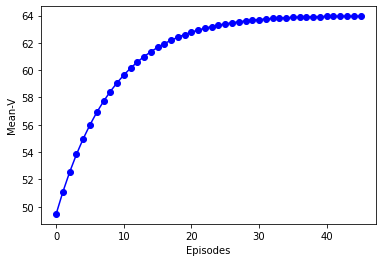

In [43]:
start = time.time()
pi = policy_iteration(env_500_P,env_500_R, gamma=0.99)
elapsed_time = time.time() - start
print(elapsed_time)
mean_v= [stat['Mean V'] for stat in pi.run_stats]
plt.plot(mean_v, color='b', marker='o')
plt.xlabel('Episodes')
plt.ylabel('Mean-V')
plt.show()

In [40]:
import collections
collections.Counter(pi.policy)

Counter({0: 47, 1: 453})

In [26]:
start = time.time()
q_learn = q_learning_forest(env_500_P,env_500_R,discount=0.99,lr_decay=.99,eps_decay=0.625)
elapsed_time = time.time() - start
print(elapsed_time)
train_scores = [st['Mean V'] for st in q_learn.run_stats]
#print(train_scores)

65.6837387084961


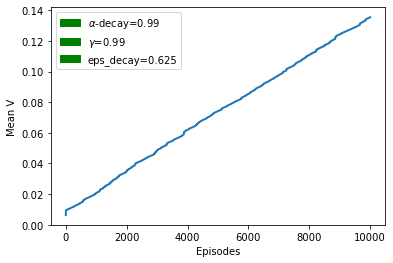

In [29]:
plot_training_graphs(train_scores)

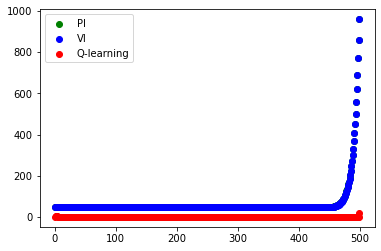

In [219]:
states = list(range(0, len(pi.V)))
plt.scatter(states, pi.V, label='PI', color='g', marker='o')
plt.scatter(states, vi.V, label='VI', color='b', marker='o')
plt.scatter(states, q_learn.V, label='Q-learning', color='r', marker='o')
plt.legend()
plt.show()

In [30]:
start = time.time()
q_learn = q_learning_forest(env_500_P,env_500_R,discount=0.99,lr_decay=.99,eps_decay=0.625, iter=10000000)
elapsed_time = time.time() - start
print(elapsed_time)
train_scores = [st['Mean V'] for st in q_learn.run_stats]

525.1951973438263


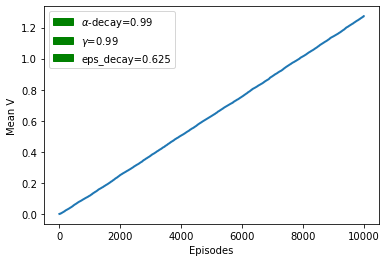

In [31]:
plot_training_graphs(train_scores)

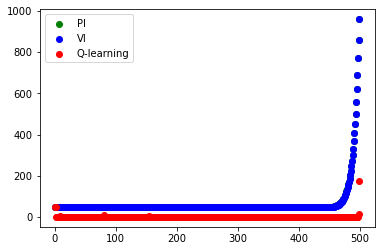

In [32]:
states = list(range(0, len(pi.V)))
plt.scatter(states, pi.V, label='PI', color='g', marker='o')
plt.scatter(states, vi.V, label='VI', color='b', marker='o')
plt.scatter(states, q_learn.V, label='Q-learning', color='r', marker='o')
plt.legend()
plt.show()

In [33]:
start = time.time()
q_learn = q_learning_forest(env_500_P,env_500_R,discount=0.99,lr_decay=.99,eps_decay=0.99, iter=10000000)
elapsed_time = time.time() - start
print(elapsed_time)
train_scores = [st['Mean V'] for st in q_learn.run_stats]

565.2384040355682


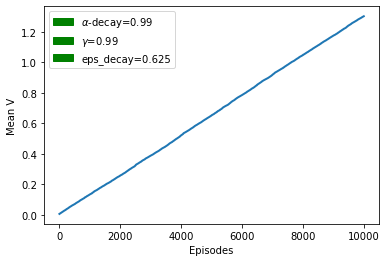

In [34]:
plot_training_graphs(train_scores)

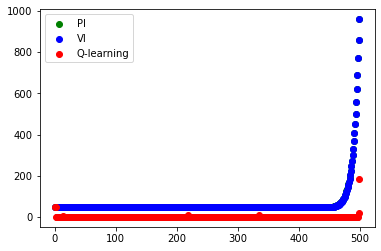

In [35]:
states = list(range(0, len(pi.V)))
plt.scatter(states, pi.V, label='PI', color='g', marker='o')
plt.scatter(states, vi.V, label='VI', color='b', marker='o')
plt.scatter(states, q_learn.V, label='Q-learning', color='r', marker='o')
plt.legend()
plt.show()